
# Tomography Segmentation Lab (scikit-image)

**Goal:** Starting from a reconstructed tomographic volume (e.g., 1017 axial slices), evaluate classical *unsupervised* segmentation methods in `scikit-image` (Otsu, Li, Triangle, Watershed), clean up artifacts, and curate a small set of high‑quality masks that will be used later to train a deep learning model.

**What you'll do:**  
1) Load a stack of slices and inspect intensity distributions.  
2) Try thresholding (Otsu, Li, Triangle) and compare segmentations quantitatively.  
3) Try Watershed with marker selection (distance transform + h-minima).  
4) Remove small speckles using morphology / connected components.  
5) Select a small subset of slices and **manually refine** masks where needed (lightweight curation).  
6) Save curated masks to a `gold_masks/` folder for future model training.



## 1) Setup & data loading

- Point `DATA_DIR` to the folder with your reconstructed slices.  
- Supported formats: TIFF, PNG, JPEG (TIFF preferred).  
- If memory is limited, you can work on a subset of indices and then switch to the full volume.


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/mnt/bgfs/projects/tomo_nano/envs/tomo/lib/python3.9/site-packages/traitlets/traitlets.py", line 632, in get
    value = obj._trait_values[self.name]
KeyError: '_control_lock'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/mnt/bgfs/projects/tomo_nano/envs/tomo/lib/python3.9/site-packages/zmq/eventloop/zmqstream.py", line 565, in _log_error
    f.result()
  File "/mnt/bgfs/projects/tomo_nano/envs/tomo/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 301, in dispatch_control
    async with self._control_lock:
  File "/mnt/bgfs/projects/tomo_nano/envs/tomo/lib/python3.9/site-packages/traitlets/traitlets.py", line 687, in __get__
    return t.cast(G, self.get(obj, cls))  # the G should encode the Optional
  File "/mnt/bgfs/projects/tomo_nano/envs/tomo/lib/python3.9/site-packages/traitlets/traitlets.py", line 6

Found 150 slices
Stack shape: (150, 1100, 1100) dtype: float64


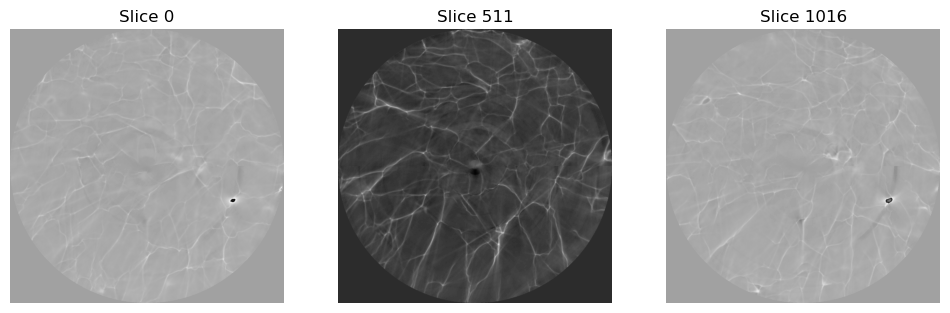

In [1]:

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from skimage import io, filters, morphology, measure, exposure, segmentation, feature, util
from skimage.filters import threshold_otsu, threshold_li, threshold_triangle, rank
from scipy import ndimage as ndi

# ---- CONFIG ----
DATA_DIR = Path("/mnt/bgfs/projects/tomo_nano/joana/data/recon_phase_int")  # <-- TODO: set this
PATTERN = "*.tiff"                        # e.g., '*.tif' or '*.png'
READ_AS_FLOAT = True                     # convert to float in [0, 1]

# Optional: restrict to a subset for quicker iteration (e.g., every 5th slice)
#STRIDE = 3      # use 1 for all slices
N_SLICES = 150  # e.g., 200 for quick tests, or None to read all

# ---- Load file list ----
files = sorted(DATA_DIR.glob(PATTERN))
n = len(files)
# if MAX_SLICES is not None:
#     files = files[:MAX_SLICES]
# files = files[::STRIDE]

indices = np.linspace(0, n - 1, N_SLICES, dtype=int)
files = [files[i] for i in indices]

print(f"Found {len(files)} slices")

# ---- Load stack ----
if len(files) == 0:
    raise FileNotFoundError("No files found. Check DATA_DIR and PATTERN.")

stack = io.imread_collection([str(f) for f in files]).concatenate()
if READ_AS_FLOAT:
    stack = util.img_as_float(stack)

print("Stack shape:", stack.shape, "dtype:", stack.dtype)

# Quick peek
mid = stack.shape[0] // 2
fig, axes = plt.subplots(1,3, figsize=(12,4))
axes[0].imshow(stack[0], cmap="gray"); axes[0].set_title(f"Slice {indices[0]}"); axes[0].axis("off")
axes[1].imshow(stack[mid], cmap="gray"); axes[1].set_title(f"Slice {indices[mid]}"); axes[1].axis("off")
axes[2].imshow(stack[-1], cmap="gray"); axes[2].set_title(f"Slice {indices[-1]}"); axes[2].axis("off")
plt.show()


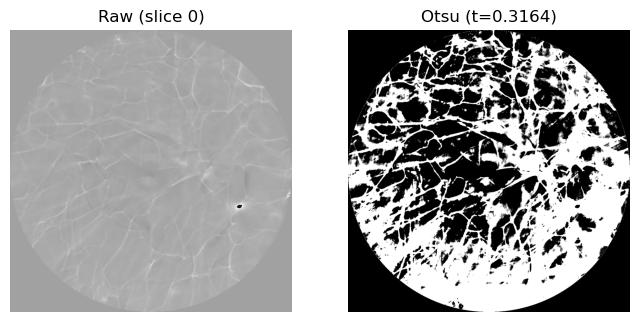

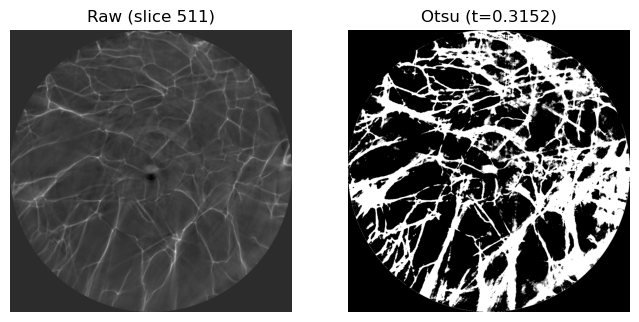

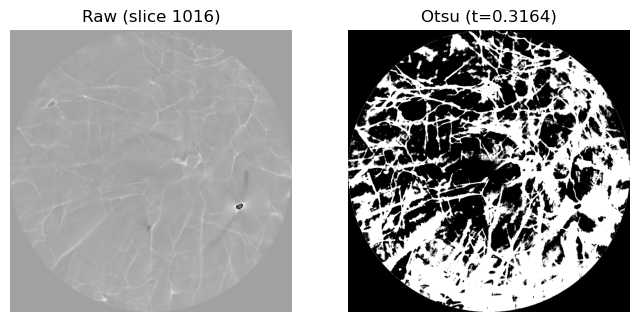

In [2]:
def apply_threshold(img):
    t_otsu  = threshold_otsu(img)
    return (img > t_otsu), t_otsu

def summarize_mask(mask):
    # Volume fraction (foreground ratio) and # of connected components
    vf = mask.mean()
    # remove small holes for component count stability (optional)
    labeled = measure.label(mask, connectivity=1)
    ncc = labeled.max()
    return vf, ncc

# Demo on a few slices
ids = [0, stack.shape[0]//2, stack.shape[0]-1]
for sid in ids:
    img = stack[sid]
    m_otsu, t1 = apply_threshold(img)

    stack_min = stack.min()
    stack_max = stack.max()
    img_norm = (img - stack_min) / (stack_max - stack_min)
    
    fig, axes = plt.subplots(1,2, figsize=(8,4))
    axes[0].imshow(img_norm, cmap="gray"); axes[0].set_title(f"Raw (slice {indices[sid]})"); axes[0].axis("off")
    axes[1].imshow(m_otsu, cmap="gray"); axes[1].set_title(f"Otsu (t={t1:.4f})"); axes[1].axis("off")
    plt.show()

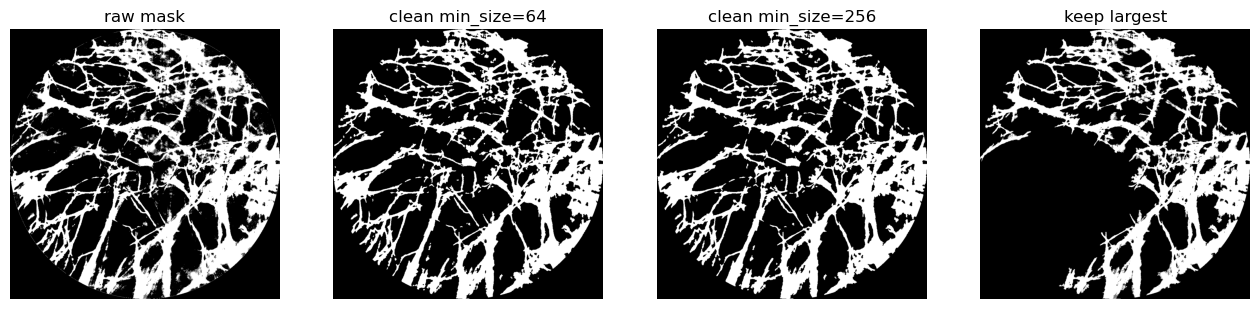

      raw_mask -> vf=0.3184, components=7917
   clean_min64 -> vf=0.2958, components=93
  clean_min256 -> vf=0.2957, components=62
  largest_only -> vf=0.2452, components=1


In [3]:
def clean_mask(mask, min_size=64, do_open=True, do_close=False):
    mm = mask.copy()
    if do_open:
        mm = morphology.binary_opening(mm, morphology.disk(1))
    if do_close:
        mm = morphology.binary_closing(mm, morphology.disk(1))
    mm = morphology.remove_small_objects(mm, min_size=min_size)
    mm = morphology.remove_small_holes(mm, area_threshold=min_size)
    return mm

# Demonstration on a mid slice
sid = stack.shape[0]//2
img = stack[sid]
m_otsu, _ = apply_threshold(img)

variants = {
    "raw_mask": m_otsu,
    "clean_min64": clean_mask(m_otsu, min_size=16, do_open=True, do_close=False),
    "clean_min256": clean_mask(m_otsu, min_size=32, do_open=True, do_close=False),
    "largest_only": measure.label(m_otsu, connectivity=1)
}

# Keep only largest component
labels = measure.label(m_otsu, connectivity=1)
if labels.max() > 0:
    counts = np.bincount(labels.ravel())
    counts[0] = 0
    largest = np.argmax(counts)
    largest_only = labels == largest
else:
    largest_only = m_otsu.copy()

variants["largest_only"] = largest_only

fig, axes = plt.subplots(1,4, figsize=(16,4))
axes[0].imshow(variants["raw_mask"], cmap="gray"); axes[0].set_title("raw mask"); axes[0].axis("off")
axes[1].imshow(variants["clean_min64"], cmap="gray"); axes[1].set_title("clean min_size=64"); axes[1].axis("off")
axes[2].imshow(variants["clean_min256"], cmap="gray"); axes[2].set_title("clean min_size=256"); axes[2].axis("off")
axes[3].imshow(variants["largest_only"], cmap="gray"); axes[3].set_title("keep largest"); axes[3].axis("off")
plt.show()

# Quantify delta in component count
for name, m in variants.items():
    vf, ncc = summarize_mask(m)
    print(f"{name:>14} -> vf={vf:.4f}, components={ncc}")


In [4]:
def segment_slice(img, method="otsu", min_size=64):
    mask = img > threshold_otsu(img)
    mask = clean_mask(mask, min_size=min_size, do_open=True, do_close=False)
    return mask

In [5]:
import pandas as pd
from tqdm import tqdm
import imageio.v2 as imageio

OUT_DIR = Path("./data/train_data")
OUT_DIR.mkdir(exist_ok=True)

def batch_segment_otsu(stack, min_size=128, save=True):
    mdir = OUT_DIR
    stack_min = stack.min()
    stack_max = stack.max()
    if save:
        mdir.mkdir(parents=True, exist_ok=True)
        (mdir / "masks_150").mkdir(parents=True, exist_ok=True)
        (mdir / "images_150").mkdir(parents=True, exist_ok=True)
        
    records = []
    
    for i in tqdm(range(stack.shape[0])):
        img = stack[i]
        img_norm = (img - stack_min) / (stack_max - stack_min)
        mask = segment_slice(img, method="otsu", min_size=min_size)
        vf, ncc = summarize_mask(mask)
        if save:
            imageio.imwrite(mdir / f"masks_150/slice_{indices[i]:04d}.png", (mask*255).astype(np.uint8))
            imageio.imwrite(mdir / f"images_150/slice_{indices[i]:04d}.png", (img_norm*255).astype(np.uint8))
        records.append({"slice": indices[i], "method": "OTSU", "vf": vf, "ncc": ncc})
    return pd.DataFrame(records)

In [6]:
df_otsu = batch_segment_otsu(stack,min_size=64,save=True)

100%|██████████| 150/150 [00:41<00:00,  3.58it/s]


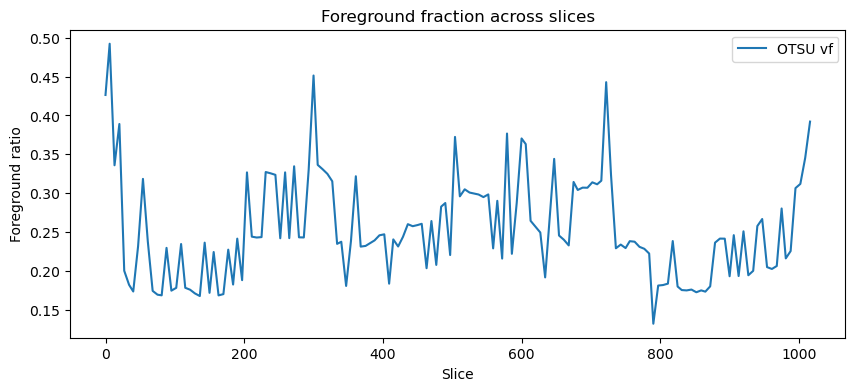

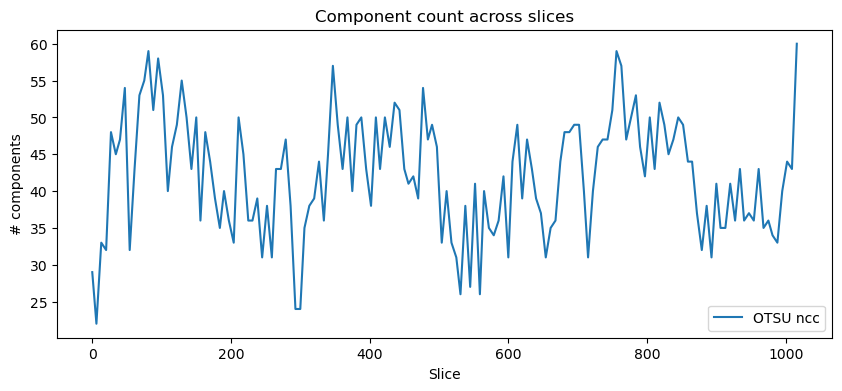

Potential outliers (|z|>3):


,slice,method,vf,ncc,vf_z
0,0,OTSU,0.426275,29,2.630394
1,6,OTSU,0.492092,22,3.635206
3,20,OTSU,0.389024,32,2.061684
44,300,OTSU,0.451275,24,3.012065
106,722,OTSU,0.442739,40,2.881742
149,1016,OTSU,0.392096,60,2.108582


In [7]:
# Plot per-method distributions
plt.figure(figsize=(10,4))
for m in df_otsu["method"].unique():
    d = df_otsu[df_otsu["method"] == m]
    plt.plot(d["slice"], d["vf"], label=f"{m} vf")
plt.title("Foreground fraction across slices")
plt.xlabel("Slice"); plt.ylabel("Foreground ratio"); plt.legend(); plt.show()

plt.figure(figsize=(10,4))
for m in df_otsu["method"].unique():
    d = df_otsu[df_otsu["method"] == m]
    plt.plot(d["slice"], d["ncc"], label=f"{m} ncc")
plt.title("Component count across slices")
plt.xlabel("Slice"); plt.ylabel("# components"); plt.legend(); plt.show()

# Flag outliers by z-score on vf per method
def zscore(x): 
    return (x - x.mean()) / (x.std() + 1e-8)

df_otsu["vf_z"] = df_otsu.groupby("method")["vf"].transform(zscore)
outliers = df_otsu[np.abs(df_otsu["vf_z"]) > 2]
print("Potential outliers (|z|>3):")
outliers.head(10)